## Importing Packages Needed

In [1]:
import numpy as np
import matplotlib.pyplot as py
from scipy.optimize import curve_fit
import collections as col
import statistics
from scipy.interpolate import UnivariateSpline

## Definition of Named Tuples

In [2]:
component = col.namedtuple('component','phase intensity')
ind_component = col.namedtuple('component','phase intensity width')
pulse_component = col.namedtuple('pulse_component','frequency comp1 comp2 errors')
component_separation = col.namedtuple('component_separation','frequency separation')

# Definition of Functions

Gaussian Fitting Functions:

In [3]:
def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))\

def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

In [4]:
"""
    Used to get the parameters, covariance matrix and errors for any number of gaussian fits, through and expected value. 
"""
def fitting_parameters(x,y,expected):
    bound=([],[])
    for i in range(len(expected)):
        bound[0].append(0)
        bound[1].append(np.inf)
        
    params,cov=curve_fit(multi_gauss,x,y,expected, bounds=bound)
    sigma=np.sqrt(np.diag(cov))
    return params, cov, sigma

Chi Squared functions

In [5]:
"""
    Compute the data's chi squared values.

    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float/list
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
"""
def chsq(observed_values, expected_values, err):
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

def chsq_err(observed_values, expected_values, err):
    #Same as above but used when there is a different error for each point
    test_statistic=0
    for observed, expected, error in zip(observed_values, expected_values, err):
        test_statistic+=((float(observed)-float(expected))/float(error))**2
    return test_statistic

Error Finding Functions

In [6]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.
    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

In [7]:
def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x

    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [8]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = sqrt.J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian

    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err

Finding Peak of Fittings Function

In [9]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all peaks of a gaussian function, where the derivative is equal to zero. 

    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    print(dy)
    py.plot(dy)
    py.title('Derivative')
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)      
    print('Maxima:',maxima)
    
    if len(maxima)==1:
        #x = np.linspace(range_min, range_max, range_max-range_min)
        dy2 = multi_gauss_d2dx2(x, *popt)
        spline_dy = UnivariateSpline(x, dy2, s=0)
        roots = spline_dy.roots()
        py.plot(dy2)

        maxroot=[]
        for root in roots:
            idx = int(root + 0.5)
            if dy[idx-1] < dy[idx]:
                maxroot.append(root)
        if len(maxroot)>1:
            if maxroot[1]>maxima[0]:
                maxima.append(maxroot[1])
    print('Maxima 2:',maxima)
    
            
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)

    return minima, maxima, minima_e, maxima_e

In [10]:
def gauss_peaks(fit, nofreqband, freqband, pcov, params,freq_low,freq_high,noise):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    pcov: list
        the covariance matrix from the fit
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    minima, peakpos, minima_e, err = find_minima_maxima_gauss(params, pcov, len(fit))
    peakint = multi_gauss(peakpos, *params)
    
    """
    #Removes peaks until only two highest remain - which also have to be the two outer peaks
    #If the highest do not correspond to the outer, the frequency band is not used
    while len(peakpos)>2:
        mn=min(peakint)
        peakint = list(peakint)
        rm = peakint.index(mn)
        if rm!=0 and rm!=len(peakpos)-1:
            del peakpos[rm]
            del peakint[rm]
            del err[rm]
        else:
            break 
    """

    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    if len(peakpos)==2 and (max(peakint)/noise)>2.5:
        component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
        component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        error = np.array(err)*(deg_mod)
    else:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0       
   
    #Converts the frequency from bins to MHz    
    freq=(((freq_high-freq_low)/nofreqband)*(nofreqband-freqband))+freq_low

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

In [11]:
"""
    Graphing Sub-pulse operation:
    Used to get the correct x, y and error arrays created for graphing the data and finding a fit.
"""
def graphing_comp(fit_comp,comp_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        for i in range(0,len(fit_comp)):
            if fit_comp[i][comp_num][0]!=0:
                phase_comp.append(fit_comp[i][comp_num][0])
                frequency_comp.append(fit_comp[i][0])
                comp_err.append(fit_comp[i][3][comp_num-1])

        return phase_comp, frequency_comp, comp_err    

Removing outliers

In [12]:
"""
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors (greater than 100 degrees).
"""
def detect_outlier(frequency_comp, phase_comp, comp_err , threshold):
    phase=[]
    frequency=[]
    err=[]
    
    #Find mean and standard deviation of data
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    for i in range(len(phase_comp)):
        #Find z score
        z_score= (phase_comp[i] - mean_1)/std_1 
        #Only include points which have a z score under the threshold value, and with errors less than 100 degrees
        if np.abs(z_score) < threshold and comp_err[i]<100:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

Plotting Fittings Functions

In [13]:
"""
    Plotting functions to plot the gaussian fit, three gaussian fit with the gaussians filled in,
    and the peaks of the gaussian fit. 
"""
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=1, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    gfit1 = gauss(x, *params1)
    gfit2 = gauss(x, *params2)

    py.plot(x, y, lw=1, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
    return 

def plot_peaks(x,y,profile_comp):
    py.plot(x,y, lw=1)
    py.plot(x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Separation Data

In [14]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))

In [15]:
"""
    Used to gain separation of components values and the uncertainties. 
"""
def separation_singleprofile(components_array):
    sep_array=[]
    uncert=[]

    #Go through all the different frequencies
    for i in range(0,len(components_array)):
        if components_array[i][1][0] != 0 and components_array[i][2][0] != 0:
            freq=components_array[i][0]
            #Subtract second component from first
            sep=(components_array[i][2][0]) - (components_array[i][1][0])
            single_sep=component_separation(frequency=freq, separation=sep)
            sep_array.append(single_sep)
            #Calculate uncertainty
            uncert.append(np.sqrt((components_array[i][3][0])**2 + (components_array[i][3][1])**2))
    return sep_array, uncert

# Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

GMRT data

In [16]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [17]:
averageprofiles = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/archive_files/B1944+17-sc-T-f4.pdv', dtype=fulldatatype)
no_freq_bands = max(averageprofiles['frequency'])+1

# INDIVIDUAL FREQUENCY BAND

Following Section is for error checking. It displays how each frequency band is fitted and it's peaks. 

#### GMRT Data Set

[ 4.95509943e-044  9.33309433e-044  1.75430010e-043 ... -3.34208988e-225
 -7.79424069e-226 -1.81400347e-226]
Maxima: [311.007066665884, 350.66527779113085]
Maxima 2: [311.007066665884, 350.66527779113085]


[200, 400, -0.05, 0.07]

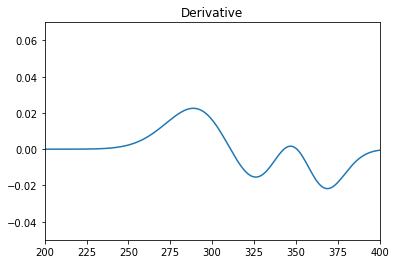

In [42]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0
f = averageprofiles['frequency'] == freqband
phase=averageprofiles['phase'][f]
intensity=averageprofiles['intensity'][f]
x = phase
y = intensity

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected=(1,315,25,0.5,350,5)

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,1113,1625,error)

py.axis([200,400,-0.05,0.07])

[200, 400, -0.5, 1.5]

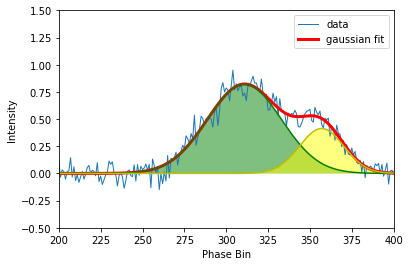

In [46]:
plot_fill(x,y,params)
py.axis([200,400,-0.5,1.5])

[70.3125, 140.625, -0.5, 1.5]

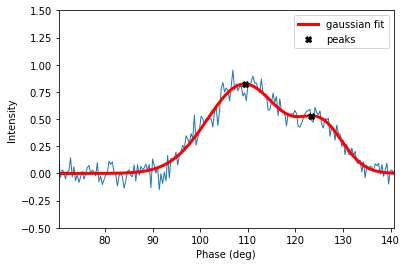

In [47]:
plot_peaks(x*(360/1024),y,profile_comp)
py.axis([70.3125,140.625,-0.5,1.5])

In [45]:
params

array([  0.82166789, 310.8473066 ,  22.08353543,   0.41316858,
       356.97194853,  13.27779035])

# ALL FREQUENCY BANDS

# Gaussian Plotting and Finding Peaks of Overall Fit


The following is a looped version of the previous section to find the correct peaks for each pulse profile

#### GMRT Data

[ 4.95509943e-044  9.33309433e-044  1.75430010e-043 ... -3.34208988e-225
 -7.79424069e-226 -1.81400347e-226]
Maxima: [311.007066665884, 350.66527779113085]
Maxima 2: [311.007066665884, 350.66527779113085]
[ 1.04334852e-053  2.28038075e-053  4.97140664e-053 ... -9.18901780e-279
 -1.51439374e-279 -2.48946584e-280]
Maxima: [310.59764150087534, 349.3544316238485]
Maxima 2: [310.59764150087534, 349.3544316238485]
[ 2.38495152e-047  4.74185811e-047  9.40686022e-047 ... -4.92481022e-245
 -1.00975658e-245 -2.06573549e-246]
Maxima: [310.61878064205945, 347.26654768346316]
Maxima 2: [310.61878064205945, 347.26654768346316]
[ 2.33220419e-046  4.57412464e-046  8.95154166e-046 ... -4.98131416e-239
 -1.05913043e-239 -2.24702053e-240]
Maxima: [311.2169105592861]
Maxima 2: [311.2169105592861, 347.8062971616696]
[ 1.32573357e-044  2.53172482e-044  4.82463594e-044 ... -1.31655644e-228
 -2.98985603e-229 -6.77567420e-230]
Maxima: [311.7821574770073, 349.66591445658116]
Maxima 2: [311.7821574770073, 349.66

/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


Maxima 2: [308.33590196070776, 341.81140212328415]
[ 4.06702930e-053  8.86248116e-053  1.92626434e-052 ... -4.84335775e-277
 -7.27055504e-278 -1.08832677e-278]
Maxima: [308.10749346612084]
Maxima 2: [308.10749346612084, 340.7659449569261]
[ 9.86651357e-051  2.05533262e-050  4.27131959e-050 ... -6.85925374e-262
 -1.26298205e-262 -2.31997193e-263]
Maxima: [310.3754076863003, 350.8621863975874]
Maxima 2: [310.3754076863003, 350.8621863975874]
[ 1.01822695e-046  1.99421911e-046  3.89717906e-046 ... -1.34093773e-239
 -2.85241740e-240 -6.05439041e-241]
Maxima: [310.57216361892824, 353.69506766102046]
Maxima 2: [310.57216361892824, 353.69506766102046]
[ 1.29941462e-041  2.35351489e-041  4.25449166e-041 ... -1.06598597e-210
 -2.73052930e-211 -6.98083487e-212]
Maxima: [311.5731908111987, 349.9567255756589]
Maxima 2: [311.5731908111987, 349.9567255756589]
[ 1.01412481e-045  1.95326713e-045  3.75412014e-045 ... -6.23816762e-232
 -1.39066467e-232 -3.09362546e-233]
Maxima: [311.8871385170903, 351.4

[ 1.83719798e-048  3.69465893e-048  7.41310679e-048 ... -2.73610974e-251
 -5.41887134e-252 -1.07076804e-252]
Maxima: [309.61090569916416, 349.1393246773273]
Maxima 2: [309.61090569916416, 349.1393246773273]
[ 5.05825257e-047  9.86323778e-047  1.91913485e-046 ... -1.14273345e-232
 -2.52280091e-233 -5.55765485e-234]
Maxima: [314.3418366885219, 357.3340732490538]
Maxima 2: [314.3418366885219, 357.3340732490538]
[ 1.53357825e-051  3.22203324e-051  6.75317767e-051 ... -7.79080368e-263
 -1.42146048e-263 -2.58728965e-264]
Maxima: [311.70195469917644, 352.54804237934667]
Maxima 2: [311.70195469917644, 352.54804237934667]
[ 1.69819553e-044  3.21464510e-044  6.07266150e-044 ... -1.10617262e-225
 -2.56673684e-226 -5.94352540e-227]
Maxima: [312.51964684572664]
Maxima 2: [312.51964684572664, 344.868238686631]
[ 4.53020964e-044  8.50974292e-044  1.59524681e-043 ... -3.99675454e-222
 -9.47908338e-223 -2.24358294e-223]
Maxima: [312.55344445502806, 352.2624498731357]
Maxima 2: [312.55344445502806, 352.

[ 3.68843072e-040  6.55926674e-040  1.16429732e-039 ... -4.94155028e-200
 -1.34407073e-200 -3.64904756e-201]
Maxima: [314.58931377374, 352.49875462238697]
Maxima 2: [314.58931377374, 352.49875462238697]
[ 1.97674711e-040  3.52707527e-040  6.28156946e-040 ... -1.74794017e-201
 -4.71320478e-202 -1.26852619e-202]
Maxima: [314.38174782968736, 352.3356220746191]
Maxima 2: [314.38174782968736, 352.3356220746191]
[ 2.49910973e-039  4.38730797e-039  7.68817812e-039 ... -9.13848569e-196
 -2.55729854e-196 -7.14339557e-197]
Maxima: [314.45127861182897, 353.28012290267486]
Maxima 2: [314.45127861182897, 353.28012290267486]
[ 6.11200840e-038  1.04748203e-037  1.79207584e-037 ... -5.12485584e-187
 -1.51878678e-187 -4.49327159e-188]
Maxima: [315.06217438402086, 352.51782856013654]
Maxima 2: [315.06217438402086, 352.51782856013654]
[ 1.65917499e-041  2.99829691e-041  5.40792779e-041 ... -2.79534053e-205
 -7.35134540e-206 -1.92963993e-206]
Maxima: [315.0106061505232, 351.7131765535708]
Maxima 2: [315.0

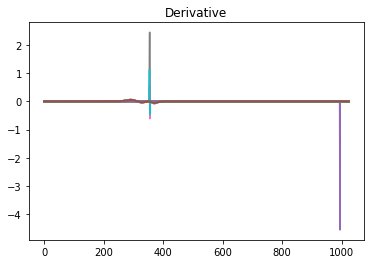

In [22]:
fit_components = []
#Taken from Peaks and Gaussian fittings of frequency band 73, in the middle
expected=(1,315,25,0.5,350,5)

#Loop thought all of the frequency bands
for i in range(0,no_freq_bands):
    freqband = i
    f = averageprofiles['frequency'] == freqband
    x=averageprofiles['phase'][f]
    y=averageprofiles['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        params,cov,sigma = fitting_parameters(x,y,expected)
        fit = multi_gauss(x,*params)
        profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params, 1113,1625,error)
  
        fit_components.append(profile_comp)

# Change of Peak Position over Frequency

Starting to graph out all the movement of component phase across frequency

## GMRT

### Component 1

<Container object of 3 artists>

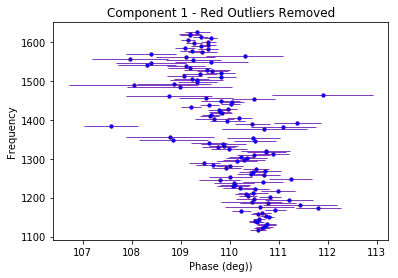

In [23]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp1, frequency_comp1, comp1_err=graphing_comp(fit_components,1)
#Plot points
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color='red', label='data')
py.title('Component 1 - Red Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
#Remove outliers which are greater than 'threshold' number of std away from the mean
#frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err,3)
#Plot outlier removed points
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color='blue',label='data')

In [24]:
#Fit the thorsett model to the component position
y_range=list(range(1113,1625))
expect=(500,0.4,16)
comp1_params,comp1_cov=curve_fit(thorsett,frequency_comp1,phase_comp1, expect, maxfev=100000, sigma=comp1_err, bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]))
comp1_fit_error=np.sqrt(np.diag(comp1_cov))
comp1_fit = thorsett(y_range, *comp1_params)
#Fit a powerlaw to component position
comp1_paramspl,comp1_covpl=curve_fit(powerlaw,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
comp1_fit_errorpl=np.sqrt(np.diag(comp1_covpl))
comp1_fitpl = powerlaw(y_range, *comp1_paramspl)
comp1_fitpl2 = powerlaw(frequency_comp1, *comp1_paramspl)

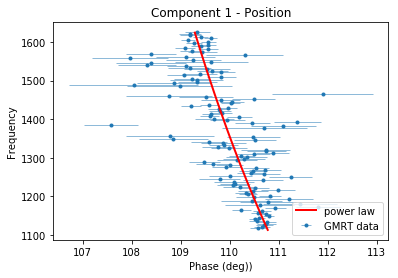

In [25]:
#Graph points with the fit ontop
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, label='GMRT data', zorder=0)
py.plot(comp1_fitpl,y_range, color='red',lw=2, label='power law', zorder=1)
py.title('Component 1 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
py.legend(loc='lower right')

In [26]:
print(f'The thorsett equation of fit for this pulse is: \t Phase = {comp1_params[0]:.3f} \u03BD^{comp1_params[1]:.3f} + {comp1_params[2]:.3f}')
print(f'The errors are {comp1_fit_error[0]}, {comp1_fit_error[1]}, {comp1_fit_error[2]} \n')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp1_paramspl[0]:.3f} \u03BD^{comp1_paramspl[1]:.3f}')
print(f'The errors are {comp1_fit_errorpl[0]}, {comp1_fit_errorpl[1]}')

The thorsett equation of fit for this pulse is: 	 Phase = 140.402 ν^-0.036 + 2.060
The errors are 3447.3939254703014, 1.2140684891117226, 3595.370921184786 

The power law equation of fit for this pulse is: 	 Phase = 142.379 ν^-0.036
The errors are 1.944363054016229, 0.001898596038128119


In [27]:
print('The chi squared reduced value is', chsq_err(phase_comp1, comp1_fitpl2, comp1_err)/(len(phase_comp1)-2))

The chi squared reduced value is 1.4795605775954792


### Component 2

[115, 130, 1100, 1650]

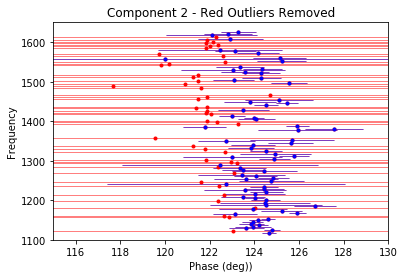

In [28]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp2, frequency_comp2, comp2_err=graphing_comp(fit_components,2)
#Plot points
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, color='red', label='data')
py.title('Component 2 - Red Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

#Remove outliers which are greater than 'threshold' number of std away from the mean
frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err,3)
#Plot outlier removed points
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, color='blue',label='data')
py.axis([115,130,1100,1650])

In [29]:
#Temporary for viewing
#print(comp2_err)
#ind=comp2_err.index(0)
#del comp2_err[ind]
#del phase_comp2[ind]
#del frequency_comp2[ind]

In [30]:
#Fit the thorsett model to the component position
#expect=(700,0.4,16)
comp2_params,comp2_cov=curve_fit(thorsett,frequency_comp2,phase_comp2, expect, maxfev=10000, sigma=comp2_err, bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]))
comp2_fit_error=np.sqrt(np.diag(comp2_cov))
comp2_fit = thorsett(y_range, *comp2_params)
#Fit a powerlaw to the component position
comp2_paramspl,comp2_covpl=curve_fit(powerlaw,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
comp2_fit_errorpl=np.sqrt(np.diag(comp2_covpl))
comp2_fitpl = powerlaw(y_range, *comp2_paramspl)
comp2_fitpl2 = powerlaw(frequency_comp2, *comp2_paramspl)

[115, 130, 1100, 1650]

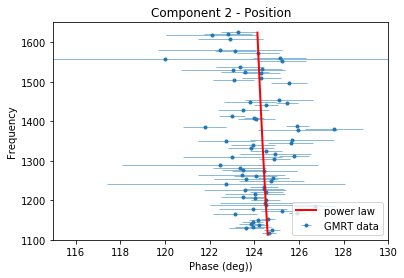

In [31]:
#Graph points with the fit ontop
py.errorbar( phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, label='GMRT data', zorder=0)
py.plot(comp2_fitpl,y_range, color='red',lw=2, label='power law', zorder=1)
py.title('Component 2 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
py.legend(loc='lower right')
py.axis([115,130,1100,1650])

In [32]:
print(f'The thorsett equation of fit for this pulse is: \t Phase = {comp2_params[0]:.3f} \u03BD^{comp2_params[1]:.3f} + {comp2_params[2]:.3f}')
print(f'The errors are {comp2_fit_error[0]}, {comp2_fit_error[1]}, {comp2_fit_error[2]} \n')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp2_paramspl[0]:.3f} \u03BD^{comp2_paramspl[1]:.3f}')
print(f'The errors are {comp2_fit_errorpl[0]}, {comp2_fit_errorpl[1]}')

The thorsett equation of fit for this pulse is: 	 Phase = 123.399 ν^-0.011 + 10.101
The errors are 174255.88823882275, 16.3239477346141, 174795.5018742669 

The power law equation of fit for this pulse is: 	 Phase = 133.472 ν^-0.010
The errors are 6.698228012559307, 0.007029279529709843


In [33]:
print('The chi squared reduced value is',chsq_err(phase_comp2, comp2_fitpl2, comp2_err)/(len(phase_comp2)-2))

The chi squared reduced value is 1.31535832400596


# Both Component Movements

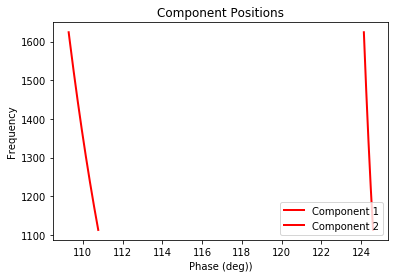

In [34]:
py.plot(comp1_fitpl,y_range, color='red',lw=2, label='Component 1', zorder=1)
py.plot(comp2_fitpl,y_range, color='red',lw=2, label='Component 2', zorder=1)
py.title('Component Positions')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
py.legend(loc='lower right')

# Fitting Power Laws to Separation 

## Just GMRT

In [35]:
#Gain component separation values
component_sep, sep_error = separation_singleprofile(fit_components)

comp_sep=[]
frequency_forsep=[]

#Put them into arrays for graphing
for i in range(0,len(component_sep)):
    comp_sep.append(component_sep[i][1])
    frequency_forsep.append(component_sep[i][0])

Text(0.5,1,'Component Separation - Red Outliers Removed')

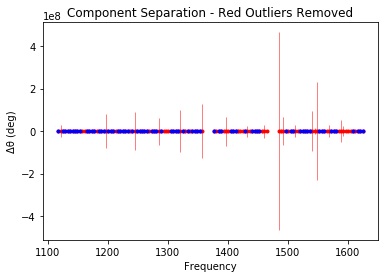

In [36]:
#Plot points
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color='red', fmt='.', lw=0.5, label='data')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

#Remove outliers
frequency_forsep, comp_sep, sep_error = detect_outlier(frequency_forsep, comp_sep, sep_error, 2.5)

#Plot points with outliers removed
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color='blue', fmt='.', lw=0.5, label='data')
py.title('Component Separation - Red Outliers Removed')

In [37]:
#Create a thorsett fit
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))
separation_fit=thorsett(frequency_forsep,*sep_params)

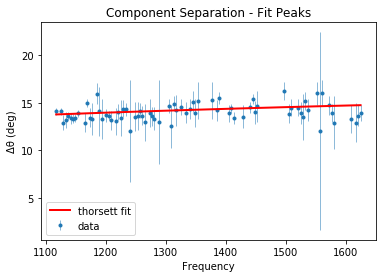

In [38]:
#Plot the thorsett fit
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data',zorder=1)
py.plot(frequency_forsep,separation_fit, color='red',lw=2,label='thorsett fit',zorder=2)
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')

In [39]:
#chi, p = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
#print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')
print('The chi squared reduced value is',chsq_err(comp_sep, separation_fit, sep_error)/(len(comp_sep)-2))

The equation of fit for this pulsar is: 	 Δθ = 1429.573 ν^0.002 + -1433.916 

The errors are 4616380.793, 5.717, 4616759.859 
Units for Δθ is degrees and ν is MHz
The chi squared reduced value is 0.6647810861360745


# Change in Intensity over Frequency for GMRT

## Fit Peaks (fit_components)

Text(0,0.5,'Intensity')

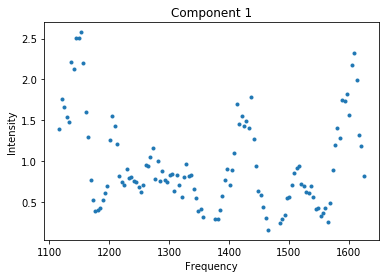

In [40]:
#Find intensity of components at each frequency and graph
intensity_comp1=[]
frequency_comp1=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp1.append(fit_components[i][1][1])
    frequency_comp1.append(fit_components[i][0])
    
py.plot(frequency_comp1,intensity_comp1, '.')
py.title('Component 1')
py.xlabel('Frequency')
py.ylabel('Intensity')

Text(0,0.5,'Intensity')

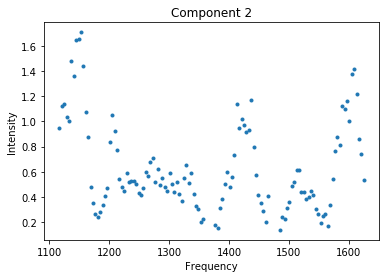

In [41]:
#Find intensity of components at each frequency and graph
intensity_comp2=[]
frequency_comp2=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp2.append(fit_components[i][2][1])
    frequency_comp2.append(fit_components[i][0])

py.plot(frequency_comp2,intensity_comp2, '.')
py.title('Component 2')
py.xlabel('Frequency')
py.ylabel('Intensity')